<a href="https://colab.research.google.com/github/Trapezun/skillfactory_rds/blob/master/project_module_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import re
import json
import datetime as dt

import unicodedata #для транслитерации не ASCII
import unidecode #для транслитерации не ASCII 

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/opinion-lexicon-english/neg_words.txt
/kaggle/input/opinion-lexicon-english/positive-words.txt
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv


In [ ]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [ ]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [ ]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [ ]:
# Cлова с позитивным отношением
df_pos_words = pd.read_csv('/kaggle/input/opinion-lexicon-english/positive-words.txt',skiprows=34, names=['word'])
pos_words_list = df_pos_words['word'].to_list() 


In [ ]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [ ]:
 #Выбираем нужные для последующего анализа столбцы
df = data[['Ranking', 'Rating', 'Number of Reviews', 'City', 'Price Range', 'Cuisine Style', 'Reviews', 'Restaurant_id', 'ID_TA', 'sample' ]].copy()

In [ ]:
df.head()

,Ranking,Rating,Number of Reviews,City,Price Range,Cuisine Style,Reviews,Restaurant_id,ID_TA,sample
0,12963.0,0.0,4.0,Paris,$$ - $$$,"['Bar', 'Pub']","[[], []]",id_0,d10746918,0
1,106.0,0.0,97.0,Helsinki,$$ - $$$,"['European', 'Scandinavian', 'Gluten Free Opti...","[['Very good reviews!', 'Fine dining in Hakani...",id_1,d6674944,0
2,810.0,0.0,28.0,Edinburgh,$$ - $$$,['Vegetarian Friendly'],"[['Better than the Links', 'Ivy Black'], ['12/...",id_2,d13129638,0
3,1669.0,0.0,202.0,London,$$$$,"['Italian', 'Mediterranean', 'European', 'Vege...","[['Most exquisite', 'Delicious and authentic']...",id_3,d680417,0
4,37.0,0.0,162.0,Bratislava,$$$$,"['Italian', 'Mediterranean', 'European', 'Seaf...","[['Always the best in bratislava', 'Very good ...",id_4,d1112354,0



# Определяю ф-ии для работы с данными

In [ ]:
allCusines = []

def get_cuisines(cuisines):
    '''
    Список кухонь, если NaN, то возвращаем 'Vegetarian Cusine' - самая популярная
    '''
    if cuisines == 'NaN': return ['Vegetarian Friendly']
    if  cuisines:
        cuisines = str(cuisines).replace("'",'"')
        return json.loads(cuisines)
    else:
        return ['Vegetarian Friendly']
    
def cuisine_styles_number(row):
    '''
    Количество видов кухонь
    '''
    global allCusines
    cusines = get_cuisines(row['Cuisine Style'])
    
    if row['Cuisine Style'] != 'NaN':    
        cusines = get_cuisines(row['Cuisine Style'])
        allCusines.extend(cusines)
        cuisines_number =len(cusines)
    else:
        cuisines_number = 1
   
    return cuisines_number


In [ ]:
def review_clean(str_in):
    '''
    Очистка текста в Review    
    '''
    try:      
        
        #middle
        str = str_in.replace("', \"","⅞").replace("', '","⅞").replace("\", '","⅞").replace("\", \"","⅞")# ", 
        str = str.replace("\", \"\"","⅞").replace("\"\", '","⅞").replace("\", \'","⅞").replace("\"\", \'","⅞")
        str = str.replace("\', \'","⅞")
        #middle
        #left
        str = str.replace("[['","≤").replace("['","⅛")
        #left
        #right
        str = str.replace("']]","≥").replace("']","⅝")
        #right
        #cleanups
        str = str.replace('\'', ' ').replace('\"', ' ').replace('\'', ' ').replace('"', ' ')     
        str = str.replace("\\", " ").replace("[[`", "≤").replace('\'"', '\'').replace('\'\"', '\'')
        str = str.replace('"\'', '\'').replace('\"\'', '\'').replace("[''" ,"≤").replace("[\'\'" ,"≤")
        str = str.replace('\'', ' ').replace('\"', ' ')
        str = str.replace('\'', ' ').replace('\"', ' ')
        str = str.replace('\'', ' ').replace('"', ' ')
        #cleanups
        #middle
        str = str.replace("⅞", "', '")
        #middle
        #left
        str = str.replace("≤", "[['").replace("⅛", "['").replace('[[ ', '[[ \'')
        #left
        #right
        str = str.replace("≥" ,"']]").replace("⅝", "']").replace(' ]', ' \']')
        str = str.replace(', nan]', '\', \'nan\']').replace('[nan, ', '[\'nan\', \'')
        #right
    except Exception:
        print('<----',str_in,'---->')
    return str


In [ ]:
def get_city_population():              
    '''
    Составил руками список городов с населением
    '''
    retval = { 
    'London': 8.173900,
    'Paris': 2.240621,
    'Madrid': 3.155360,
    'Barcelona': 1.593075,
    'Berlin': 3.326002,
    'Milan': 1.331586,
    'Rome': 2.870493,
    'Prague': 1.272690,
    'Lisbon': .547733,
    'Vienna': 1.765649,
    'Amsterdam': .825080,
    'Brussels': .144784,
    'Edinburgh': .482005,
    'Hamburg': 1.718187,
    'Munich': 1.364920,
    'Lyon': .496343,
    'Stockholm': 1.981263,
    'Budapest': 1.744665,
    'Warsaw': 1.720398,
    'Dublin': .506211 ,
    'Copenhagen': 1.246611,
    'Athens': 3.168846,
    'Zurich': .402275,
    'Oporto': .221800,
    'Geneva': .196150,
    'Krakow': .756183,
    'Oslo': .673469,
    'Helsinki': .574579,
    'Bratislava': .413192,
    'Luxembourg': .576249,
    'Ljubljana': .277554
    }
    return retval


In [ ]:
def positive_words_number(reviews):
    '''
    Количество позитивных слов в отзывах
    '''
    pos_words_count = 0
    txts=get_reviews(reviews)['reviews_txt']
    txt = ' '.join(txts)    
    words = createWordList(txt)
    
    words_count = len(words) if len(words) > 0 else 1
    words_count = 1
    pos_words_in_review=set(words).intersection(pos_words_list)
    for word in words:
        if word in pos_words_list:
            #print(word)
            pos_words_count +=1  
    return np.round(pos_words_count/words_count,2)

    
def createWordList(line):
    wordList2 =[]
    wordList1 = line.split()
    for word in wordList1:
        cleanWord = ""
        for char in word:
            if char in '!,.?":;0123456789':
                char = ""
            cleanWord += char
        wordList2.append(cleanWord.lower())
    return wordList2

def get_reviews(rev):
    '''
    Получаем review в виде:
    review['reviews_txt'][1] - list of reviews
    review['reviews_dt'][1] - list of reviews dates
    '''
    if  not pd.isna(rev): 
        rev = str(rev).replace("'",'"')
        rev = rev.replace('], [', '], "reviews_dt": [')
        rev = '{ "reviews_txt":' + rev + '}'
        rev = rev.replace('[[','[').replace(']]',']')
        d = json.loads(rev)

        d['reviews_dt'] = [dt.datetime.strptime(date, '%m/%d/%Y').date() if len(date.split('/')[2])==4 else dt.datetime.strptime(date, '%m/%d/%y').date() for date in d['reviews_dt']]
        return d
    else:
        return {}

In [ ]:
def rev_time_diff(reviews):
    '''
    Количество дней между review
    '''
    if (pd.notna(reviews)):
        reviews_dt_list = get_reviews(reviews)['reviews_dt']
        if reviews_dt_list:
            return (max(reviews_dt_list) - min(reviews_dt_list)).days
        else:
            return dt.timedelta(days=3650).days
    else:
        return dt.timedelta(days=3650).days

    

    



## Обработка данных. Одновременно создание новых признаков и удаление Nan 

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
Ranking              50000 non-null float64
Rating               50000 non-null float64
Number of Reviews    46800 non-null float64
City                 50000 non-null object
Price Range          32639 non-null object
Cuisine Style        38410 non-null object
Reviews              49998 non-null object
Restaurant_id        50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
dtypes: float64(3), int64(1), object(6)
memory usage: 3.8+ MB


In [ ]:
#Посмотрим на признаки уникальные значения
df.nunique(dropna=False)

Ranking              12975
Rating                  10
Number of Reviews     1574
City                    31
Price Range              4
Cuisine Style        10732
Reviews              41858
Restaurant_id        13094
ID_TA                49963
sample                   2
dtype: int64

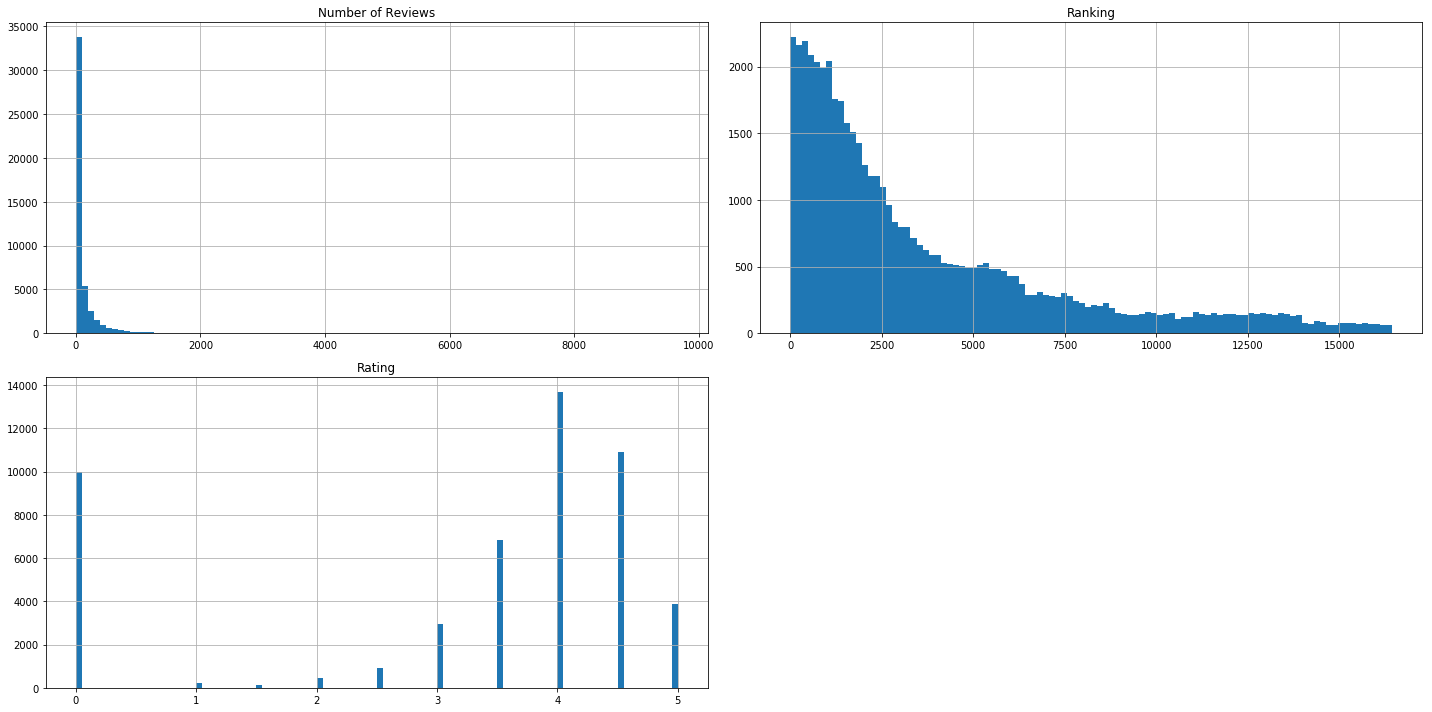

In [ ]:
df[['Ranking', 'Rating', 'Number of Reviews','Price Range', 'Restaurant_id']].hist(figsize=(20, 10), bins=100);
plt.tight_layout()

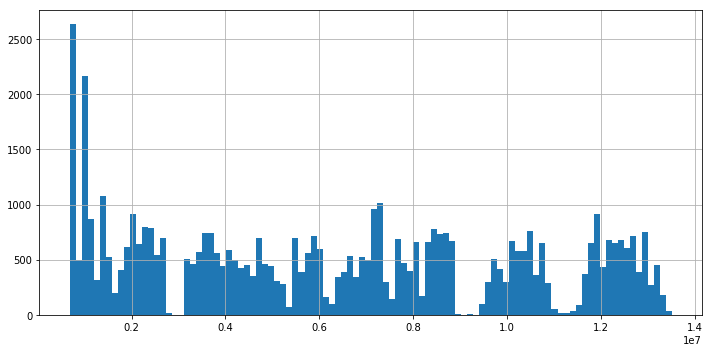

In [ ]:
df['ID_TA'].apply(lambda x: x[1:]).astype(int).hist(figsize=(10, 5), bins=100);
plt.tight_layout()
# получили какие-то группы. надо этот признак оставить.

In [ ]:
df['ID_TA'] = df['ID_TA'].apply(lambda x: x[1:]) 

In [ ]:
# Reviews - Сохраняем где был NaN
df['Reviews_txt_NaN'] = df['Reviews'].apply(lambda x: x ==  '[[], []]')



In [ ]:
df['Reviews'] = df['Reviews'].fillna('[[], []]')
df['Reviews'] = df['Reviews'].apply(lambda x: review_clean(x))

In [ ]:
# Price Range - удаляем NaN и кодируем в 1, 2, 3
price_nums = {'Price Range':     {"$": 1, "$$ - $$$": 2, "$$$$": 3, np.NaN: 2}} # самый частый "$$ - $$$" => 2
df['Price Range NAN'] = df['Price Range'].isna()
df.replace(price_nums, inplace=True)

In [ ]:
# Удаляем NaN
# Получаем Cuisines Count - количество кухонь в ресторане
df['Cuisine Style NAN'] = df['Cuisine Style'].isna()
df['Cuisine Style'] = df['Cuisine Style'].fillna('NaN')
df['Cuisines Count'] = df.apply(cuisine_styles_number, axis=1)

#самая популярная кухня
most_popular_cusine = pd.Series(allCusines).value_counts().index[0]
#most_popular_cusine  => 'Vegetarian Friendly'

#среднее к-во кухонь в ресторане
average_cousines_count = np.round(df['Cuisines Count'].mean())
#average_cousines_count => 3.0 

In [ ]:
# Number of Reviews - Nan заменяем на среднее
df['Number of Reviews NAN'] = df['Number of Reviews'].isna()
replace_val = df['Number of Reviews'].mean()
replace_val = np.round(replace_val)
df['Number of Reviews'] = df['Number of Reviews'].fillna(replace_val)

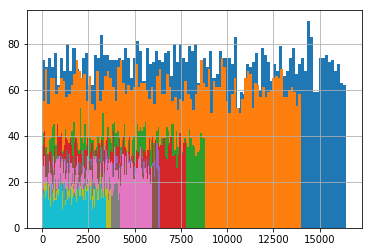

In [ ]:
#Распределение Ranking по городам
for x in (df['City'].value_counts())[0:10].index:
    df['Ranking'][df['City'] == x].hist(bins=100)
plt.show()

In [ ]:
# Есть смещение в городах, но это можно поправить, если использовать нормированный параметр
mean_Ranking_on_City = df.groupby(['City'])['Ranking'].mean()
count_Restorant_in_City = df['City'].value_counts(ascending=False)
df['mean_Ranking_on_City'] = df['City'].apply(lambda x: mean_Ranking_on_City[x])
df['count_Restorant_in_City'] = df['City'].apply(lambda x: count_Restorant_in_City[x])
df['norm_Ranking_on_Rest_in_City'] = (df['Ranking'] - df['mean_Ranking_on_City']) / df['count_Restorant_in_City']


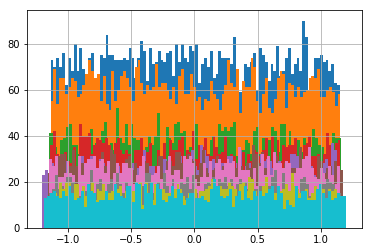

In [ ]:
# что получилось для 10 городов
for x in (df['City'].value_counts())[0:10].index:
    df['norm_Ranking_on_Rest_in_City'][df['City'] == x].hist(bins=100)
plt.show()

In [ ]:
#В ходе испытаний выяснилось, что лучше еще добавить группировку по максимальному рангу
max_Ranking_on_City = df.groupby(['City'])['Ranking'].max()
df['max_Ranking_on_City'] = df['City'].apply(lambda x: max_Ranking_on_City[x])
df['norm_Ranking_on_maxRank_in_City'] = (df['Ranking'] - df['mean_Ranking_on_City']) / df['max_Ranking_on_City']

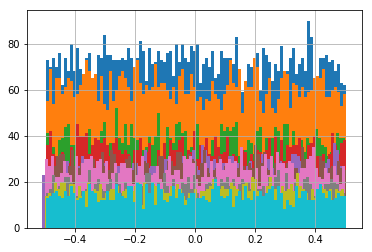

In [ ]:
# что получилось для 10 городов
for x in (df['City'].value_counts())[0:10].index:
    df['norm_Ranking_on_maxRank_in_City'][df['City'] == x].hist(bins=100)
plt.show()

In [ ]:
# Вычисляем к-во ресторанов для городе
restorants_in_city =  df['City'].value_counts(ascending=False)
df['Restaurants Count'] = df['City'].map(restorants_in_city)

In [ ]:
# Вычисляем население (в тыс. чел) для города в каждой строке
population_city_dict = get_city_population()
df['Population'] = df["City"].map(population_city_dict)

In [ ]:
# Вычисляем к-во ресторанов на 1000 чел для города
df['Restaurants for Population'] = df['Restaurants Count'] / (df['Population']*1000) #

In [ ]:
# isMostPopCusine - есть ли в ресторане самая популярная кухня; 
# isMultyCusine - к-во кухонь в ресторане больше или столько же чем в среднем
df['isMostPopCusine'] = df['Cuisine Style'].apply(lambda x: 1 if most_popular_cusine in x else 0 )
df['isMultyCusine'] = df['Cuisines Count'].apply(lambda x: 1 if  x >= average_cousines_count else 0 )

In [ ]:
# К-во позитивных слов в представленных отзывах
df['PositiveWords'] = df['Reviews'].apply(lambda x: positive_words_number(x))

In [ ]:
# Кол-во дней между отзывами
df['RevTimeDelta'] = df['Reviews'].apply(rev_time_diff)

In [ ]:
#Преобразую колонки с True/False в 1/0

df['Reviews_txt_NaN'] =  df['Reviews_txt_NaN'].astype(int)
df['Price Range NAN'] =  df['Price Range NAN'].astype(int)
df['Cuisine Style NAN'] =  df['Cuisine Style NAN'].astype(int)
df['Number of Reviews NAN'] =  df['Number of Reviews NAN'].astype(int)
df['ID_TA'] = df['ID_TA'].astype(int)


In [ ]:
#делаю dummies из City

df = pd.get_dummies(df, columns=[ 'City',], dummy_na=True)

In [ ]:
#собираю колонки, которые содержат цифровые данные
df_preproc = df.loc[:, df.dtypes != object]
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 55 columns):
Ranking                            50000 non-null float64
Rating                             50000 non-null float64
Number of Reviews                  50000 non-null float64
Price Range                        50000 non-null int64
ID_TA                              50000 non-null int64
sample                             50000 non-null int64
Reviews_txt_NaN                    50000 non-null int64
Price Range NAN                    50000 non-null int64
Cuisine Style NAN                  50000 non-null int64
Cuisines Count                     50000 non-null int64
Number of Reviews NAN              50000 non-null int64
mean_Ranking_on_City               50000 non-null float64
count_Restorant_in_City            50000 non-null int64
norm_Ranking_on_Rest_in_City       50000 non-null float64
max_Ranking_on_City                50000 non-null float64
norm_Ranking_on_maxRank_in_City    5000

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [ ]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [ ]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df = df_input[['Ranking', 'Rating', 'Number of Reviews', 'City', 'Price Range', 'Cuisine Style', 'Reviews', 'Restaurant_id', 'ID_TA', 'sample' ]].copy()
    
    
    
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df['ID_TA'] = df['ID_TA'].apply(lambda x: x[1:]) 
    df[df['Reviews']=='[[], []]']
    df['Reviews_txt_NaN'] = df['Reviews'].apply(lambda x: x ==  '[[], []]')
    df['Reviews'] = df['Reviews'].fillna('[[], []]')
    df['Reviews'] = df['Reviews'].apply(lambda x: review_clean(x))
    cleanup_nums = {'Price Range':     {"$": 1, "$$ - $$$": 2, "$$$$": 3, np.NaN: 2}} # чаще всего встречается "$$ - $$$" == 2
    df['Price Range NAN'] = df['Price Range'].isna()
    df.replace(cleanup_nums, inplace=True)       
    df['Cuisine Style NAN'] = df['Cuisine Style'].isna()
    df['Cuisine Style'] = df['Cuisine Style'].fillna('NaN')
    df['Cuisines Count'] = df.apply(cuisine_styles_number, axis=1)

    most_popular_cusine = pd.Series(allCusines).value_counts().index[0]
    average_cousines_count = np.round(df['Cuisines Count'].mean())
    
    df['Number of Reviews NAN'] = df['Number of Reviews'].isna()
    replace_val = df['Number of Reviews'].mean()
    replace_val = np.round(replace_val)
    df['Number of Reviews'] = df['Number of Reviews'].fillna(replace_val)
    
    
    mean_Ranking_on_City = df.groupby(['City'])['Ranking'].mean()
    count_Restorant_in_City = df['City'].value_counts(ascending=False)
    df['mean_Ranking_on_City'] = df['City'].apply(lambda x: mean_Ranking_on_City[x])
    df['count_Restorant_in_City'] = df['City'].apply(lambda x: count_Restorant_in_City[x])
    df['norm_Ranking_on_Rest_in_City'] = (df['Ranking'] - df['mean_Ranking_on_City']) / df['count_Restorant_in_City']
    
    max_Ranking_on_City = df.groupby(['City'])['Ranking'].max()
    df['max_Ranking_on_City'] = df['City'].apply(lambda x: max_Ranking_on_City[x])
    df['norm_Ranking_on_maxRank_in_City'] = (df['Ranking'] - df['mean_Ranking_on_City']) / df['max_Ranking_on_City']
                 
    restorants_in_city =  df['City'].value_counts(ascending=False)
    df['Restaurants Count'] = df['City'].map(restorants_in_city)
    df['Population'] = df["City"].map(population_city_dict)
    df['Restaurants for Population'] = df['Restaurants Count'] / (df['Population']*1000) #
    df['RevTimeDelta'] = df['Reviews'].apply(rev_time_diff)
    df['PositiveWords'] = df['Reviews'].apply(lambda x: positive_words_number(x))
    df['Reviews_txt_NaN'] =  df['Reviews_txt_NaN'].astype(int)
    df['Price Range NAN'] =  df['Price Range NAN'].astype(int)
    df['Cuisine Style NAN'] =  df['Cuisine Style NAN'].astype(int)
    df['Number of Reviews NAN'] =  df['Number of Reviews NAN'].astype(int)
    df['ID_TA'] = df['ID_TA'].astype(int)
    df = pd.get_dummies(df, columns=[ 'City',], dummy_na=True)
   
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    df_output = df.loc[:, df.dtypes != object]
    
    return df_output

#### Запускаем и проверяем что получилось

In [ ]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

,Ranking,Rating,Number of Reviews,Price Range,ID_TA,sample,Reviews_txt_NaN,Price Range NAN,Cuisine Style NAN,Cuisines Count,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
8590,249.0,0.0,897.0,2,737184,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
39525,1568.0,3.5,90.0,2,6704176,1,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
34849,1283.0,4.0,9.0,2,9776760,1,1,0,0,4,...,0,0,0,0,0,0,0,0,0,0
495,5701.0,0.0,124.0,2,12516807,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
19247,11453.0,4.0,6.0,1,7598013,1,0,0,0,2,...,0,0,1,0,0,0,0,0,0,0
8305,4379.0,0.0,16.0,1,7745225,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
32763,2034.0,4.0,48.0,1,3138066,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
48335,3135.0,4.0,126.0,2,4020178,1,0,0,0,2,...,0,0,1,0,0,0,0,0,0,0
21045,81.0,4.0,307.0,2,776787,1,0,0,0,5,...,0,0,0,0,0,0,0,0,0,0
20663,1888.0,2.5,44.0,3,1111830,1,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 53 columns):
Ranking                            50000 non-null float64
Rating                             50000 non-null float64
Number of Reviews                  50000 non-null float64
Price Range                        50000 non-null int64
ID_TA                              50000 non-null int64
sample                             50000 non-null int64
Reviews_txt_NaN                    50000 non-null int64
Price Range NAN                    50000 non-null int64
Cuisine Style NAN                  50000 non-null int64
Cuisines Count                     50000 non-null int64
Number of Reviews NAN              50000 non-null int64
mean_Ranking_on_City               50000 non-null float64
count_Restorant_in_City            50000 non-null int64
norm_Ranking_on_Rest_in_City       50000 non-null float64
max_Ranking_on_City                50000 non-null float64
norm_Ranking_on_maxRank_in_City    5000

In [ ]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [ ]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 52), (40000, 52), (40000, 51), (32000, 51), (8000, 51))

# Model 
Сам ML

In [ ]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [ ]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [ ]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [ ]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20078375


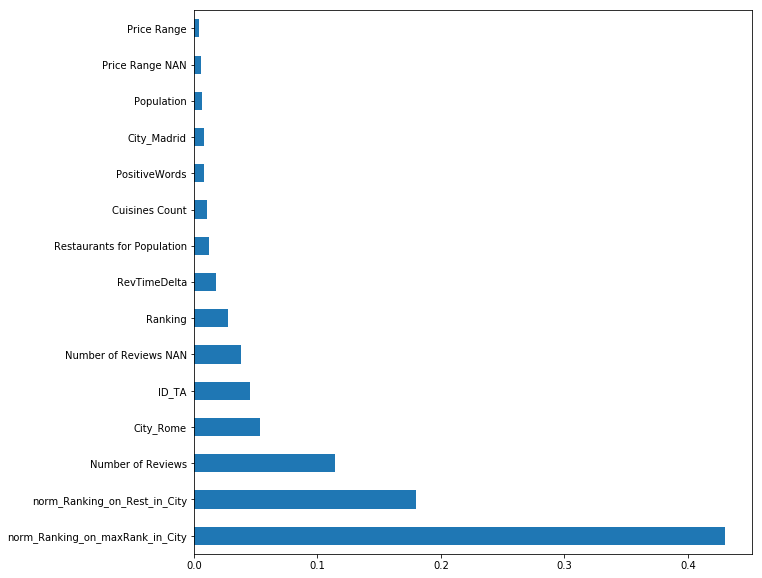

In [ ]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [ ]:
test_data.sample(10)

,Ranking,Rating,Number of Reviews,Price Range,ID_TA,Reviews_txt_NaN,Price Range NAN,Cuisine Style NAN,Cuisines Count,Number of Reviews NAN,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
8854,594.0,0.0,49.0,2,2287478,0,0,0,3,0,...,0,0,0,0,0,0,0,0,0,0
8463,3612.0,0.0,112.0,1,3255139,0,0,0,3,0,...,0,0,0,0,0,0,0,0,0,0
1189,13688.0,0.0,4.0,2,5810138,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4714,748.0,0.0,38.0,2,7061140,0,0,0,6,0,...,0,0,0,0,0,0,0,0,0,0
4193,3131.0,0.0,121.0,1,6575627,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
6153,2862.0,0.0,4.0,3,10509018,1,0,0,5,0,...,0,0,0,0,0,0,0,0,0,0
5018,1776.0,0.0,325.0,2,8406963,0,0,0,2,0,...,0,0,0,0,1,0,0,0,0,0
6618,3389.0,0.0,4.0,2,13196774,1,1,1,1,0,...,0,0,0,0,0,0,1,0,0,0
3186,3418.0,0.0,34.0,1,10174068,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
8755,9722.0,0.0,11.0,1,7278616,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
test_data = test_data.drop(['Rating'], axis=1)

In [ ]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [ ]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [ ]:
predict_submission

array([3.155, 4.23 , 4.175, ..., 3.055, 4.31 , 4.225])

In [ ]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.155
1,id_1,4.230
2,id_2,4.175
3,id_3,4.355
4,id_4,4.410
5,id_5,4.495
6,id_6,1.945
7,id_7,2.805
8,id_8,4.210
9,id_9,4.690


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
